In [2]:
##############################################################################
#	Project		:	Age Estimation
#	Pipeline	:	E2ePipeline2
#	Date		:	1.11.2023
# 	Description	: 	Main run file
##############################################################################

import shutil

# importing the sys module
import sys        
 
# appending the directory of mod.py
# in the sys.path list
sys.path.append('../')   

import json
import os
import random
from collections import defaultdict

import torch
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.optim import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from datetime import datetime
from Common.Datasets.Morph2.data_parser import DataParser
from tqdm import tqdm

from Common.Optimizers.RangerLars import RangerLars
from Common.Schedulers.GradualWarmupScheduler import GradualWarmupScheduler
from Common.Analysis.GeneralMethods import get_statistics_range

import ep2_config as cfg
from ep2_dataset import QueryAndMultiAgeRefsDataset
from ep2_model import DiffBasedAgeDetectionModel
from ep2_train import train



#####################################################
#           Preparations
#####################################################

torch.manual_seed(cfg.RANDOM_SEED)
np.random.seed(cfg.RANDOM_SEED)
random.seed(cfg.RANDOM_SEED)

if cfg.USE_GPU:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print(device)

torch.cuda.empty_cache()

#####################################################
#           Data Loading
#####################################################

# Load data
data_parser = DataParser('../Common/Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5', small_data=cfg.SMALL_DATA)
data_parser.initialize_data()


x_train, y_train, x_test, y_test, chosen_idxs_trn, chosen_idxs_tst = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test, data_parser.chosen_idxs_trn, data_parser.chosen_idxs_tst
if cfg.RANDOM_SPLIT:
    all_images = np.concatenate((x_train, x_test), axis=0)
    all_labels = np.concatenate((y_train, y_test), axis=0)

    x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=cfg.TEST_SIZE_FOR_RS, random_state=cfg.RANDOM_SEED)

#####################################################
#           Metadata Loading
#####################################################

# Emebeddings
face2emb_arr_trn_r = np.load('face2emb_arr_trn_recog.npy', allow_pickle=True)
face2emb_arr_vld_r = np.load('face2emb_arr_vld_recog.npy', allow_pickle=True)

if cfg.SMALL_DATA:
    face2emb_arr_trn_r = face2emb_arr_trn_r[chosen_idxs_trn]
    face2emb_arr_vld_r = face2emb_arr_vld_r[chosen_idxs_tst]
    

with open("im2age_map_test_after_improve1.json", 'r') as im2age_map_test_f:
	im2age_map_test = json.load(im2age_map_test_f)
                  


test_err_distribution = get_statistics_range(dataset_metadata=y_test,
                                       dataset_indexes=[i for i in range(len(y_test))],#chosen_idxs_tst, 
                                       im2age_map_batst=im2age_map_test,
                                        age_range_min=0, 
                                        age_range_max=90)

print(f"""mean : {test_err_distribution["mean"]}, std : {test_err_distribution["std"]}, count : {test_err_distribution["count"]}""")


cuda:0
mean : 0.2958741099929306, std : 3.3469429388142684, count : 10606


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 4.000e+00, 2.000e+00, 1.200e+01, 1.300e+01, 4.300e+01,
        6.300e+01, 1.280e+02, 2.730e+02, 4.370e+02, 6.560e+02, 1.050e+03,
        1.340e+03, 1.548e+03, 1.325e+03, 1.147e+03, 8.260e+02, 6.020e+02,
        4.230e+02, 2.820e+02, 1.640e+02, 8.600e+01, 7.700e+01, 4.400e+01,
        2.300e+01, 1.400e+01, 7.000e+00, 6.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-26.29582977, -25.27376003, -24.25169029, -23.22962055,
        -22.20755081, -21.18548107, -20.16341133, -19.14134159,
        -18.11927185, -17.09720211, -16.07513237, -15.05306263,
        -14.03099289, -13.00892315, -11.98685341, -10.96478367,
         -9.94271393,  -8.92064419,  -7.89857445,  -6.87650471,
         -5.85443497,  -4.83236523,  -3.81029549,  -2.78

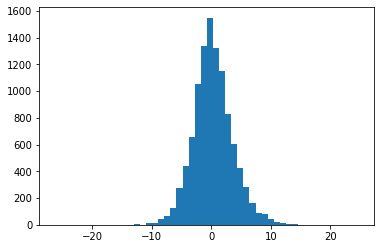

In [7]:
import matplotlib.pyplot as plt
plt.hist(test_err_distribution["data"], bins=50)
#print(test_err_distribution["data"])

In [6]:
mae_age = np.mean(np.abs(test_err_distribution["data"]))
print(f"MAE : {mae_age}")

MAE : 2.5487053210434545


In [ ]:
test_err_distribution = get_statistics_range(dataset_metadata=y_test,
                                       dataset_indexes=[i for i in range(len(y_test))],#chosen_idxs_tst, 
                                       im2age_map_batst=im2age_map_test,
                                        age_range_min=0, 
                                        age_range_max=49)

print(f"""mean : {test_err_distribution["mean"]}, std : {test_err_distribution["std"]}, count : {test_err_distribution["count"]}""")


In [ ]:
import matplotlib.pyplot as plt
plt.hist(test_err_distribution["data"],bins=20)
#print(test_err_distribution["data"])